**2. 데이터 수집**

In [346]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

repositories = pd.read_csv('repositories.csv')
train_set, test_set = train_test_split(repositories, test_size=0.2, random_state=42)

In [347]:
repositories["Language"].value_counts()
# 개수가 500 이상인 언어만 저장
language_counts = repositories["Language"].value_counts()
language_counts = language_counts[language_counts >= 500]
repositories = repositories[repositories["Language"].isin(language_counts[language_counts >= 500].index)]

In [348]:
# "Topics" 열의 리스트를 분해하여 각 주제를 별도의 행으로 만들기
topics_expanded = repositories.explode("Topics")

# Top 5 주제 식별
top_5_topics = topics_expanded["Topics"].value_counts().head(5).index

# Top 5 주제만 필터링
topic_filter = topics_expanded[topics_expanded["Topics"].isin(top_5_topics)]

**3. 데이터 시각화**

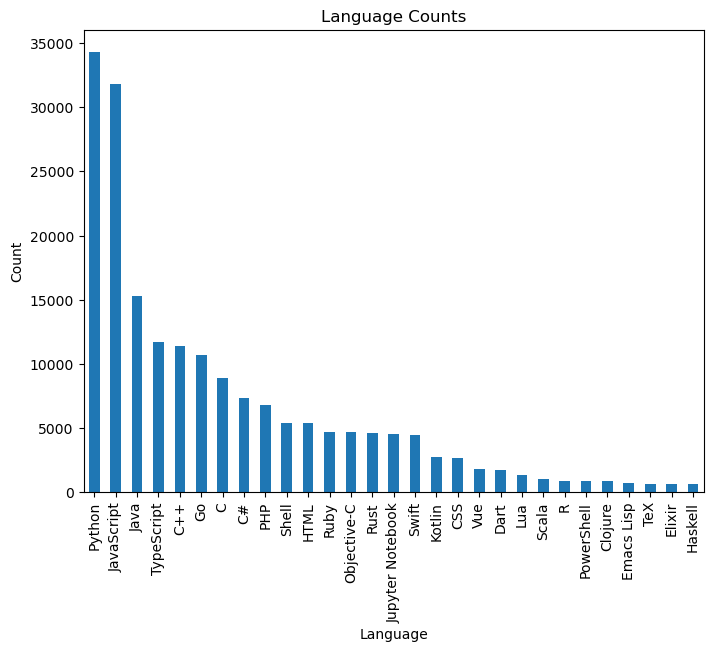

In [349]:
plt.figure(figsize=(8, 6))
language_counts.plot(kind="bar")
plt.title("Language Counts")
plt.xlabel("Language")
plt.ylabel("Count")

plt.show()

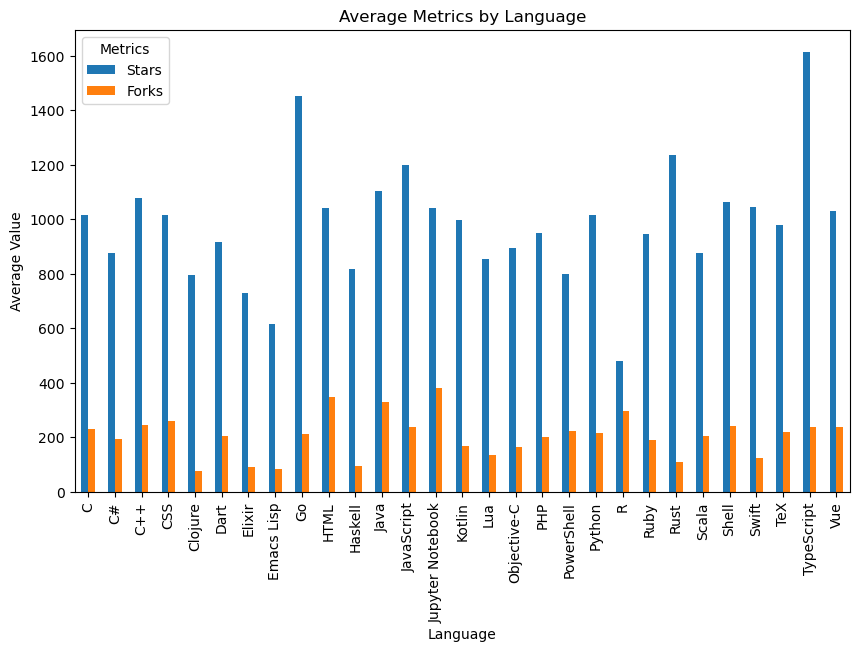

In [350]:
language_grouped_data = repositories.groupby("Language")[["Stars", "Forks"]].mean()

# 그래프 생성
language_grouped_data.plot(kind="bar", figsize=(10, 6))
plt.title("Average Metrics by Language")
plt.xlabel("Language")
plt.ylabel("Average Value")
plt.legend(title="Metrics")

# 그래프를 화면에 표시
plt.show()

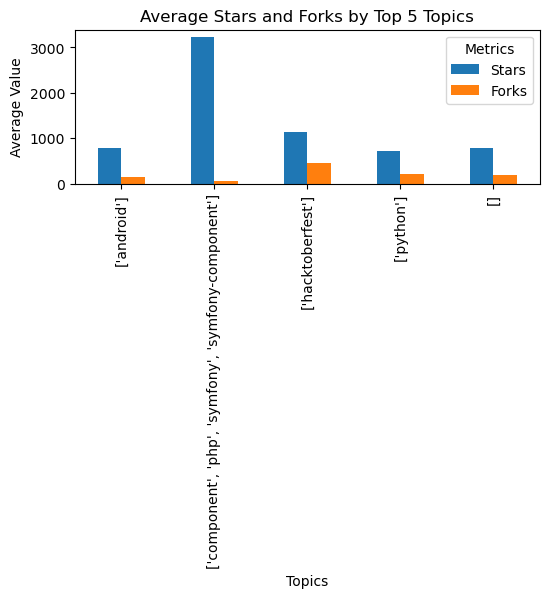

In [351]:
topic_grouped_data = topic_filter.groupby("Topics")[["Stars", "Forks"]].mean()

topic_grouped_data.head()

topic_grouped_data.plot(kind="bar", figsize=(6, 2))
plt.title("Average Stars and Forks by Top 5 Topics")
plt.xlabel("Topics")
plt.ylabel("Average Value")
plt.legend(title="Metrics")

# 그래프를 화면에 표시
plt.show()

**4. 데이터 정제**

In [352]:
# 결측치 제거
# Language 열이 빈 값인 행 제거
repositories = repositories.dropna(subset=["Language"])

# Topics 열이 빈 배열인 행 제거
repositories = repositories[repositories["Topics"].apply(len) > 0]

In [353]:
#숫자가 들어가야 할 공간에 이상한 문자가 들어있는 경우 정제
def clean_and_convert(value):
    try:
        # 숫자를 추출하고 공백 및 쉼표 등을 제거
        cleaned_value = ''.join(filter(str.isdigit, str(value)))
        # 정수로 변환
        return int(cleaned_value)
    except ValueError:
        # 변환할 수 없는 경우에는 NaN 또는 원하는 다른 처리 수행
        return None
    
repositories['Stars'] = repositories['Stars'].apply(clean_and_convert)
repositories['Forks'] = repositories['Forks'].apply(clean_and_convert)

repositories = repositories.dropna(subset=['Stars', 'Forks'])

# stars개수가 100 미만인 컬럼 삭제
repositories = repositories[repositories['Stars'] > 500]
repositories = repositories[repositories['Stars'] < 20000]
repositories = repositories.dropna()

In [354]:
necessary_data = ['Stars', 'Forks', 'Language', 'Topics']
repositories = repositories[necessary_data]

In [355]:
repositories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28292 entries, 1061 to 83139
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Stars     28292 non-null  int64 
 1   Forks     28292 non-null  int64 
 2   Language  28292 non-null  object
 3   Topics    28292 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [356]:
# 특성 스케일링을 위해 숫자형 데이터 저장
repositories_num = repositories[['Stars', 'Forks']]

In [357]:
repositories_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28292 entries, 1061 to 83139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Stars   28292 non-null  int64
 1   Forks   28292 non-null  int64
dtypes: int64(2)
memory usage: 663.1 KB


**5. 텍스트와 범주형 특성 다루기**

In [358]:
repositories_language = repositories[["Language"]]
repositories_language.head(8)

,Language
1061,JavaScript
1065,Elixir
1067,JavaScript
1068,Python
1070,Java
1072,Python
1073,Go
1075,Java


In [359]:
from sklearn.preprocessing import OneHotEncoder

# 순서가 없는 범주기 때문에 원핫인코더 사용
language_encoder = OneHotEncoder()
repositories_language_1hot = language_encoder.fit_transform(repositories_language)

In [360]:
repositories_language_1hot

<28292x29 sparse matrix of type '<class 'numpy.float64'>'
	with 28292 stored elements in Compressed Sparse Row format>

In [361]:
repositories_language_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [362]:
# 데이터프레임에 원 핫 인코딩 테스트
language_encoder.categories_

[array(['C', 'C#', 'C++', 'CSS', 'Clojure', 'Dart', 'Elixir', 'Emacs Lisp',
        'Go', 'HTML', 'Haskell', 'Java', 'JavaScript', 'Jupyter Notebook',
        'Kotlin', 'Lua', 'Objective-C', 'PHP', 'PowerShell', 'Python', 'R',
        'Ruby', 'Rust', 'Scala', 'Shell', 'Swift', 'TeX', 'TypeScript',
        'Vue'], dtype=object)]

In [363]:
df_test = pd.DataFrame({"Languages": ["Python", "JavaScript"]})
df_test

,Languages
0,Python
1,JavaScript


In [364]:
pd.get_dummies(df_test)

,Languages_JavaScript,Languages_Python
0,0,1
1,1,0


**6. 특성 스케일링 및 변환**

In [365]:
# 머신 러닝 모델의 성능을 향상시키기 위한 전처리 과정
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
repositories_num_min_max_scaled = min_max_scaler.fit_transform(repositories_num)

In [366]:
# 정규분포
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
repositories_num_std_scaled = std_scaler.fit_transform(repositories_num)

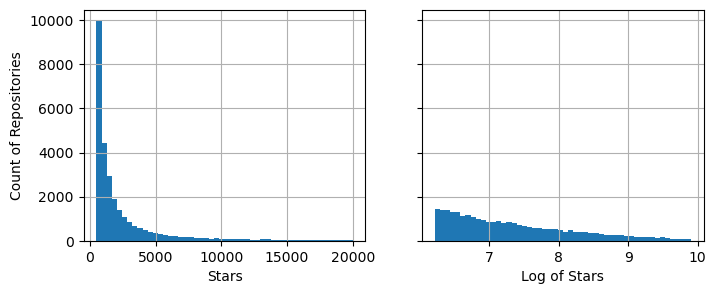

In [367]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
repositories["Stars"].hist(ax=axs[0], bins=50)
# 데이터를 보다 대칭적으로 표시하기 위해 log를 씌움
repositories["Stars"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Stars")
axs[1].set_xlabel("Log of Stars")
axs[0].set_ylabel("Count of Repositories")
plt.show()

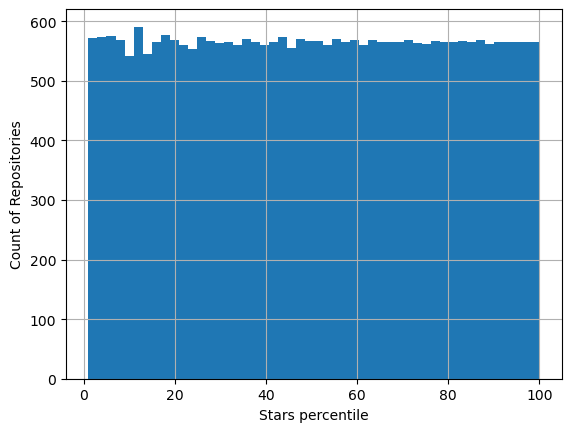

In [368]:
# 특정 값이 전체 어디에 위치하는지 퍼센테이지로 확인
percentiles = [np.percentile(repositories["Stars"], p)
               for p in range(1, 100)]
flattened_reopsitories = pd.cut(repositories["Stars"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_reopsitories.hist(bins=50)
plt.xlabel("Stars percentile")
plt.ylabel("Count of Repositories")
plt.show()

**7. 사용자 정의 변환기**

In [369]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 0또는 음수 방지
        X['Stars'] = np.log1p(X['Stars'] + 1)
        X[self.column_name] = np.log1p(X[self.column_name])
        return X

# 이전에 이미 특성 스케일링 변화를 했기 때문에 이 값을 사용하지는 않을 예정
log_transformer = LogTransformer(column_name="Stars")
transformed_data = log_transformer.transform(repositories)

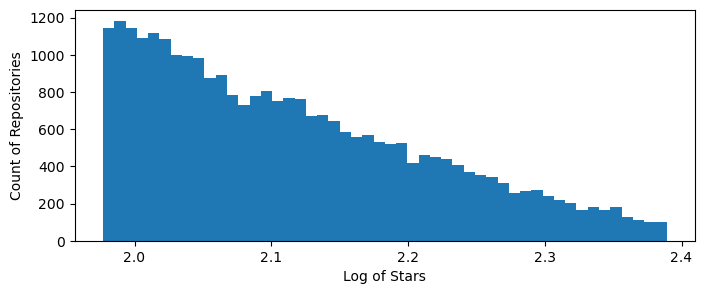

In [370]:
# "Stars" 열에 대한 히스토그램을 그립니다.
plt.figure(figsize=(8, 3))
plt.hist(transformed_data['Stars'], bins=50)
plt.xlabel("Log of Stars")
plt.ylabel("Count of Repositories")
plt.show()

**8. 변환 파이프라인**

In [371]:
# 파이프라인 시각화를 위하여 diagram 옵션 설정
sklearn.set_config(display="diagram")

In [372]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 특징 엔지니어링
preprocessor = ColumnTransformer(
    transformers=[
        ('lang_encoder', OneHotEncoder(), ['Language'])
    ])

# 파이프라인 구축
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [373]:
# 데이터를 학습용(train)과 평가용(test)으로 나눔
X = repositories.drop('Stars', axis=1)
y = repositories['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이프라인을 사용하여 모델 학습
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('lang_encoder',
                                                  OneHotEncoder(),
                                                  ['Language'])])),
                ('model', LinearRegression())])

**9. 모델 선택과 훈련**

In [374]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

X = repositories[["Language"]]
y = repositories["Stars"]

# 파이프라인 구축
# 과적합을 줄이고 비선형 관계를 처리할 수 있는 랜덤 포레스트 활용
rf_reg = make_pipeline(preprocessor, RandomForestRegressor())

# 모델 학습
rf_reg.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('lang_encoder',
                                                  OneHotEncoder(),
                                                  ['Language'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [375]:
new_data = {
    "Language": ["Python", "C++", "Ruby"]
}

new_data_df = pd.DataFrame(new_data)

# 모델을 사용하여 예측
predictions = rf_reg.predict(new_data_df)

# 예측 결과 출력
print("Predictions:", predictions)

Predictions: [2.1120683  2.1140838  2.10288169]


In [376]:
from sklearn.model_selection import cross_val_score

# 교차 검증 수행
scores = cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores

# MSE 평균 및 표준 편차 출력
print("Mean MSE:", mse_scores.mean())
print("Standard Deviation of MSE:", mse_scores.std())

Mean MSE: 0.015724595847910035
Standard Deviation of MSE: 0.015253259765026131


**10. 모델 세부 튜닝**

In [377]:
from sklearn.model_selection import GridSearchCV

# "Language" 열에 대해 원-핫 인코딩을 수행
X_encoded = pd.get_dummies(X, columns=["Language"], prefix=["Language"])

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# 모델 및 그리드 탐색 수행
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_encoded, y)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 200}


In [378]:
# 기존 데이터의 언어 목록을 가져옵니다
existing_languages = X_encoded.columns

# 새로운 데이터에 대한 예측
new_data = {
    "Language": ["Python", "C++", "Ruby"]
}
# 새로운 데이터를 데이터프레임으로 생성
new_data_df = pd.DataFrame(new_data)

# 새로운 데이터에 대해 원-핫 인코딩을 수행하고 기존 언어 목록을 기준으로 열을 생성
new_data_encoded = pd.get_dummies(new_data_df, columns=["Language"], prefix=["Language"])
# 기존 언어 목록과 일치하도록 열을 추가
for lang in existing_languages:
    if lang not in new_data_encoded.columns:
        new_data_encoded[lang] = 0

# 모델을 사용하여 예측
predictions = best_rf_reg.predict(new_data_encoded[X_encoded.columns])

# 예측 결과 출력
print("Predictions:", predictions)

Predictions: [2.1119535  2.11278159 2.10492518]


In [379]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 하이퍼파라미터 그리드 정의 (랜덤 탐색은 분포를 지정할 수 있음)
param_dist = {
    'n_estimators': np.arange(100, 1000, 100),  # 100에서 900까지 100 단위로 랜덤 선택
    'max_depth': [None] + list(np.arange(10, 31, 1)),  # None 또는 10에서 30까지 1 단위로 랜덤 선택
}

# 모델 정의
rf_reg = RandomForestRegressor()

# 랜덤 탐색 수행
random_search = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)

# 학습 데이터로 랜덤 탐색 실행
random_search.fit(X_encoded, y)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 300, 'max_depth': 16}


In [380]:
# 원래 X_encoded의 열 순서를 가져옵니다.
column_order = X_encoded.columns

# 새로운 데이터에 대해 원-핫 인코딩 수행
new_data_encoded = pd.get_dummies(new_data_df, columns=["Language"], prefix=["Language"])

# 누락된 열을 0으로 채우기
missing_cols = set(column_order) - set(new_data_encoded.columns)
for col in missing_cols:
    new_data_encoded[col] = 0

# 열 순서를 맞춥니다.
new_data_encoded = new_data_encoded[column_order]

# 예측
predictions = best_rf_reg.predict(new_data_encoded)

# 예측 결과 출력
print("Predictions:", predictions)

Predictions: [2.1119535  2.11278159 2.10492518]


In [381]:
original_predictions = np.exp(predictions)
original_predictions = np.exp(original_predictions)
print(original_predictions)

[3883.02572888 3909.70219877 3664.65326153]


In [386]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성
rf_reg = RandomForestRegressor(n_estimators=300, max_depth=16)

# 교차 검증을 통한 모델 성능 평가 (평균 제곱 오차)
mse_scores = -cross_val_score(rf_reg, X_encoded, y, scoring="neg_mean_squared_error", cv=5)

# 모델 평가 점수 출력
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("Standard Deviation of MSE:", mse_scores.std())

MSE Scores: [0.04280631 0.00443511 0.00099094 0.00870162 0.02165152]
Mean MSE: 0.015717098552049235
Standard Deviation of MSE: 0.015247311118352017


Feature Importances: [0.00255934 0.01190708 0.0057614  0.00333172 0.01863382 0.03081081
 0.01106015 0.00838581 0.41370643 0.01703993 0.01925979 0.01106107
 0.03436138 0.00370676 0.01470524 0.00724179 0.00324786 0.0035157
 0.00203926 0.00439735 0.19342318 0.02218542 0.03255884 0.00244822
 0.00464447 0.00424618 0.00206671 0.10897376 0.00272051]


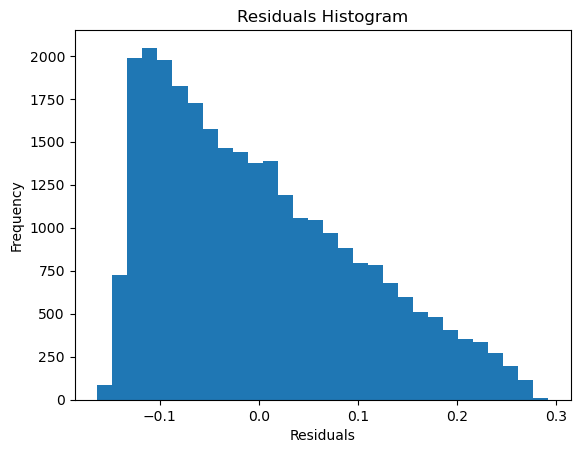

In [387]:
# 모델 피팅
rf_reg.fit(X_encoded, y)

# 모델의 특성 중요도 확인
feature_importances = rf_reg.feature_importances_
print("Feature Importances:", feature_importances)

# 오차 분포 시각화
import matplotlib.pyplot as plt
predicted_values = rf_reg.predict(X_encoded)
residuals = y - predicted_values
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.show()

In [388]:
from sklearn.metrics import mean_squared_error

# 테스트 데이터로 예측 수행
y_pred = rf_reg.predict(X_test_encoded)

# 모델의 예측값과 실제값 간의 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.010038505902910822


In [389]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.10019234453245827
